# Laboratorio 4: Analisis y visualización de Datos

## ***Introducción***

# Análisis Bivariado de Temperatura y Precipitación en la Región de Coquimbo

## Introducción

Este análisis tiene como objetivo visualizar y entender la relación espacial entre la temperatura máxima y la precipitación en distintas estaciones meteorológicas ubicadas en la Región de Coquimbo. Utilizando datos de monitoreo ambiental de diversas estaciones, se busca generar un **mapa bivariado** que combine ambas variables para analizar cómo varían conjuntamente en el espacio.

### Objetivos
1. **Visualizar los puntos de monitoreo** en el mapa junto con los límites geográficos de la Región de Coquimbo.
2. **Calcular y analizar estadísticas descriptivas** de las variables de temperatura máxima y precipitación.
3. **Clasificar los datos en cuantiles** para ambas variables, de manera que se pueda generar una representación bivariada en el mapa.
4. **Generar un mapa bivariado** que permita visualizar la relación entre las clases de temperatura y precipitación en las diferentes estaciones meteorológicas.
5. **Interpretar los resultados** obtenidos a partir de la visualización y análisis de los datos espaciales.

### Datos Utilizados
- **Datos meteorológicos**: Estos incluyen valores diarios de temperatura máxima (°C) y precipitación (mm) registrados en diversas estaciones de monitoreo dentro de la Región de Coquimbo.

https://climatologia.meteochile.gob.cl/


- **Shapefile geográfico**: Límites geográficos de la Región de Coquimbo, utilizados para situar espacialmente las estaciones y generar las visualizaciones necesarias.

https://www.bcn.cl/siit/mapas_vectoriales/index_html

### Metodología
1. **Preprocesamiento de los datos**: Normalización y verificación de los valores extremos.
2. **Análisis estadístico**: Cálculo de estadísticas descriptivas para cada variable con el fin de comprender su distribución.
3. **Clasificación bivariada**: Utilización de **cuantiles** para dividir los datos de temperatura y precipitación en clases.
4. **Visualización**: Creación de un **mapa bivariado** que muestre la relación espacial entre ambas variables.

### Herramientas
- **Python**: Para la manipulación de los datos y la creación de visualizaciones.
- **GeoPandas**: Para trabajar con datos geoespaciales y realizar uniones espaciales entre las estaciones meteorológicas y los límites geográficos.
- **Matplotlib**: Para graficar los resultados y generar mapas.


## Descripción del Dataset

El dataset utilizado en este análisis contiene información de estaciones meteorológicas que monitorean temperatura y precipitación en la Región de Coquimbo. A continuación se detallan las columnas del dataset y su estructura.

### Estructura del Dataset
- **Número de registros**: 526,430
- **Número de columnas**: 7

### Columnas del Dataset

1. **Estacion** (`object`):  
   Nombre de la estación meteorológica donde se realizaron las mediciones. No contiene valores nulos.
   
2. **lat** (`float64`):  
   Latitud de la ubicación geográfica de la estación. No contiene valores nulos.
   
3. **long** (`float64`):  
   Longitud de la ubicación geográfica de la estación. No contiene valores nulos.
   
4. **Fecha** (`datetime64[ns]`):  
   Fecha de la medición registrada, en formato de fecha. No contiene valores nulos.
   
5. **Valor_T_max** (`float64`):  
   Valor de la temperatura máxima (°C) registrada en la estación para el día correspondiente. Contiene 64,003 valores no nulos.
   
6. **Valor_T_min** (`float64`):  
   Valor de la temperatura mínima (°C) registrada en la estación para el día correspondiente. Contiene 64,512 valores no nulos.
   
7. **Valor_Pp_mm** (`float64`):  
   Valor de la precipitación (mm) registrada en la estación para el día correspondiente. Contiene 292,235 valores no nulos.

### Notas sobre los Datos
- Las columnas de temperatura y precipitación contienen valores nulos debido a la falta de registros en algunas estaciones o días específicos.
- Las columnas de latitud y longitud permiten ubicar espacialmente las estaciones en un mapa geográfico, lo que facilita la visualización espacial de los datos.


In [359]:
"""@author: César Godoy Delaigue"""
import pandas as pd
import numpy as np
import xlrd
import pyodbc
import sqlalchemy
import unicodedata
import openpyxl
import matplotlib.pyplot as plt


# 1. Exploración de Datos (EDA)

## 1.1 Carga de los datos

Cargamos el dataset y verificamos la estructura de los datos.

In [371]:
# Ruta del archivo Excel a leer
ruta = r"C:\Entorno_Desarrollo_UDD\Visualizacion_de_la_Informacion\notebook\Tareas\DataSet_metereologia.csv"


# Leer el archivo Excel en un DataFrame
df_importa_data = pd.read_csv(ruta, sep=',', encoding='utf-8')  

# Mostrar los primeros registros del DataFrame
print(df_importa_data.head()) ## Guardar el dataframe en un archivo csv

     Estacion        lat       long       Fecha  Valor_T_max  Valor_T_min  \
0  AgroChacay -31.863935 -70.616477  1998-02-08          NaN          NaN   
1  AgroChacay -31.863935 -70.616477  1998-03-29          NaN          NaN   
2  AgroChacay -31.863935 -70.616477  1998-04-14          NaN          NaN   
3  AgroChacay -31.863935 -70.616477  1998-04-24          NaN          NaN   
4  AgroChacay -31.863935 -70.616477  1998-05-18          NaN          NaN   

   Valor_Pp_mm  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN  


In [372]:
df_importa_data.columns 

Index(['Estacion', 'lat', 'long', 'Fecha', 'Valor_T_max', 'Valor_T_min',
       'Valor_Pp_mm'],
      dtype='object')

In [373]:
df_importa_data.shape

(526430, 7)

In [374]:
df_importa_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 526430 entries, 0 to 526429
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Estacion     526430 non-null  object 
 1   lat          526430 non-null  float64
 2   long         526430 non-null  float64
 3   Fecha        526430 non-null  object 
 4   Valor_T_max  64003 non-null   float64
 5   Valor_T_min  64512 non-null   float64
 6   Valor_Pp_mm  292235 non-null  float64
dtypes: float64(5), object(2)
memory usage: 28.1+ MB


* Cálculo de Coordenadas Geometricas

***Código importa la clase Point del módulo shapely.geometry y luego calcula una nueva columna llamada 'Coordenadas' en el DataFrame df_importa_data. Esta nueva columna contiene objetos Point que representan las coordenadas geográficas basadas en las columnas 'long' y 'lat' del DataFrame.***

In [375]:
from shapely.geometry import Point

# Calculate the 'Coordenadas' column as a geometry point
df_importa_data['Coordenadas'] = df_importa_data.apply(lambda row: Point(row['long'], row['lat']), axis=1)
print(df_importa_data.head())

     Estacion        lat       long       Fecha  Valor_T_max  Valor_T_min  \
0  AgroChacay -31.863935 -70.616477  1998-02-08          NaN          NaN   
1  AgroChacay -31.863935 -70.616477  1998-03-29          NaN          NaN   
2  AgroChacay -31.863935 -70.616477  1998-04-14          NaN          NaN   
3  AgroChacay -31.863935 -70.616477  1998-04-24          NaN          NaN   
4  AgroChacay -31.863935 -70.616477  1998-05-18          NaN          NaN   

   Valor_Pp_mm                                    Coordenadas  
0          NaN  POINT (-70.61647709322419 -31.86393477004859)  
1          NaN  POINT (-70.61647709322419 -31.86393477004859)  
2          NaN  POINT (-70.61647709322419 -31.86393477004859)  
3          NaN  POINT (-70.61647709322419 -31.86393477004859)  
4          NaN  POINT (-70.61647709322419 -31.86393477004859)  


In [376]:
df_importa_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 526430 entries, 0 to 526429
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Estacion     526430 non-null  object 
 1   lat          526430 non-null  float64
 2   long         526430 non-null  float64
 3   Fecha        526430 non-null  object 
 4   Valor_T_max  64003 non-null   float64
 5   Valor_T_min  64512 non-null   float64
 6   Valor_Pp_mm  292235 non-null  float64
 7   Coordenadas  526430 non-null  object 
dtypes: float64(5), object(3)
memory usage: 32.1+ MB


## 1.2 Tratamiento de Valores Faltantes

Revisamos los tipos de datos y la cantidad de valores nulos para determinar si necesitamos imputar o eliminar valores faltantes.

In [377]:
df_importa_data.isnull().sum()

Estacion            0
lat                 0
long                0
Fecha               0
Valor_T_max    462427
Valor_T_min    461918
Valor_Pp_mm    234195
Coordenadas         0
dtype: int64

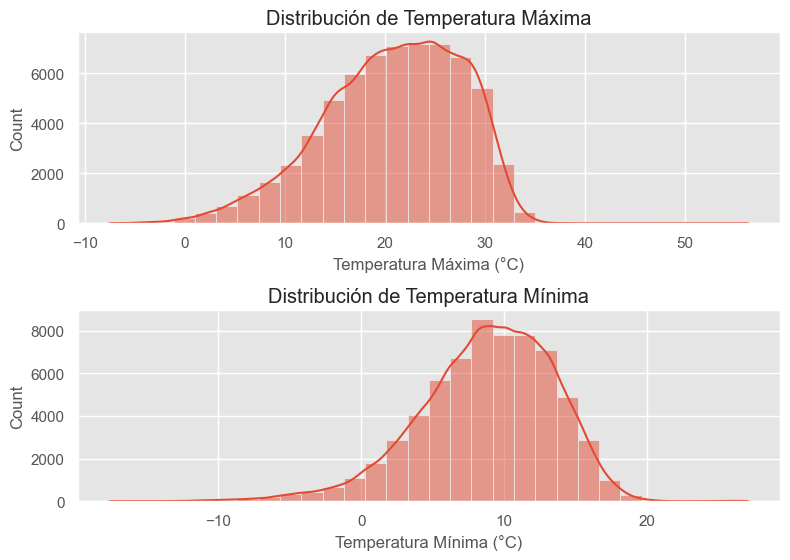

In [378]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Visualizar la distribución de las variables numéricas
plt.figure(figsize=(8, 8))

# Gráfico de distribución para Temperatura Máxima
plt.subplot(3, 1, 1)
sns.histplot(df_importa_data['Valor_T_max'], bins=30, kde=True)
plt.title('Distribución de Temperatura Máxima')
plt.xlabel('Temperatura Máxima (°C)')

# Gráfico de distribución para Temperatura Mínima
plt.subplot(3, 1, 2)
sns.histplot(df_importa_data['Valor_T_min'], bins=30, kde=True)
plt.title('Distribución de Temperatura Mínima')
plt.xlabel('Temperatura Mínima (°C)')

# Mostrar todos los gráficos
plt.tight_layout()
plt.show()

In [379]:
# Seleccionar solo las columnas numéricas que no sean las coordenadas
columnas_interes = df_importa_data.select_dtypes(include=['float64', 'int64']).columns.difference(['Coordenadas', 'lat', 'long'])   

# Aplicar describe a las columnas seleccionadas
df_importa_data[columnas_interes].describe().T.style.background_gradient(subset=['mean', 'std', '50%', 'count'], cmap='PuBu')

,count,mean,std,min,25%,50%,75%,max
Valor_Pp_mm,292235.000000,0.570429,4.380330,0.000000,0.000000,0.000000,0.000000,207.300000
Valor_T_max,64003.000000,20.836596,6.878571,-7.500000,16.210000,21.450000,26.200000,56.300000
Valor_T_min,64512.000000,8.786161,4.695915,-17.600000,6.000000,9.200000,12.200000,27.070000


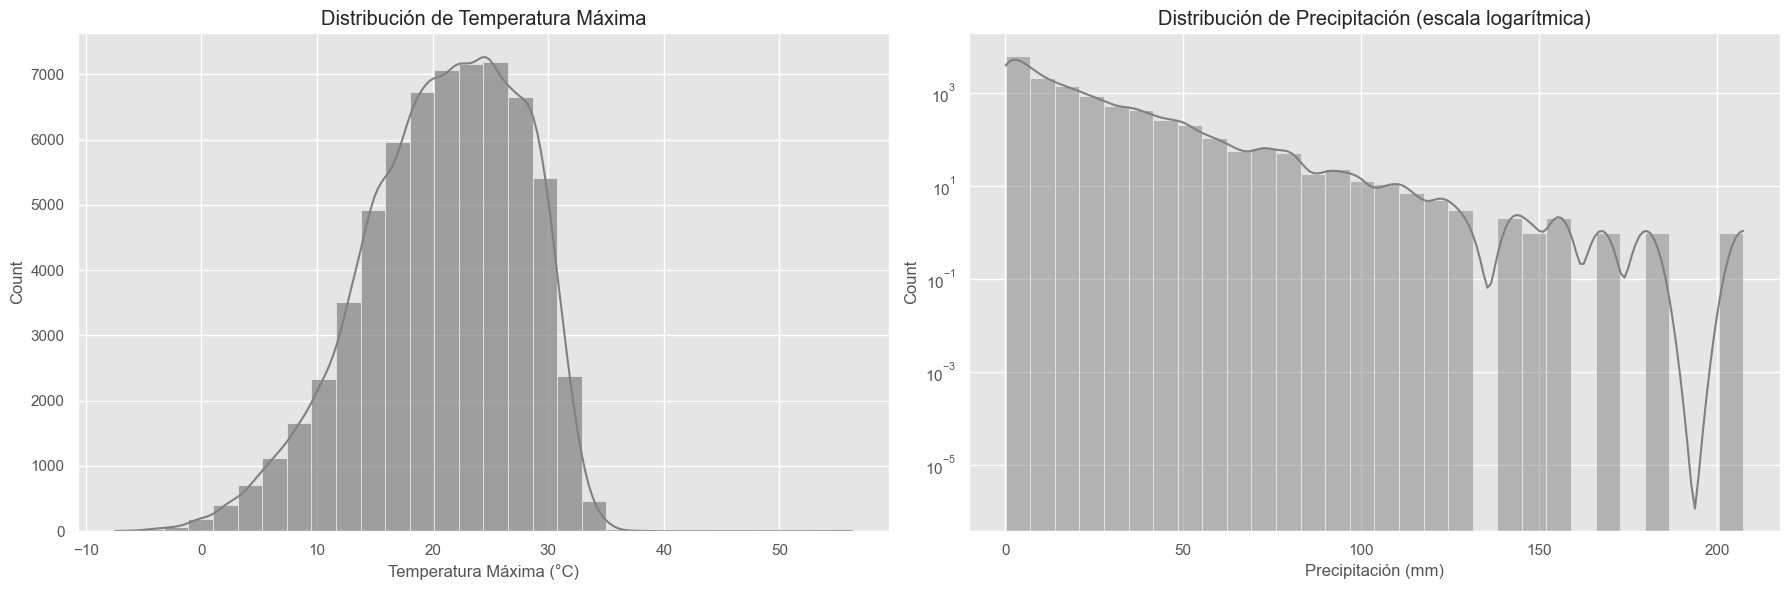

In [380]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de estilo para los gráficos
plt.style.use('ggplot')

# Gráfico con escala logarítmica para la precipitación
plt.figure(figsize=(18, 6))

# Gráfico de distribución para Temperatura Máxima
plt.subplot(1, 2, 1)
sns.histplot(df_importa_data['Valor_T_max'], bins=30, kde=True, color='grey', alpha=0.7)
plt.title('Distribución de Temperatura Máxima')
plt.xlabel('Temperatura Máxima (°C)')

# Gráfico de distribución para Precipitación en escala logarítmica
plt.subplot(1, 2, 2)
sns.histplot(df_importa_data['Valor_Pp_mm'].replace(0, pd.NA), bins=30, kde=True, color='grey')  # Reemplaza ceros por NaN para la visualización
plt.yscale('log')  # Cambiar a escala logarítmica
plt.title('Distribución de Precipitación (escala logarítmica)')
plt.xlabel('Precipitación (mm)')

# Mostrar todos los gráficos
plt.tight_layout()
plt.show()


## 1.3 inputación valores faltantes

DataFrame debe estar ordenado correctamente y que la columna de fecha está configurada como índice si vas a trabajar con series temporales.

In [381]:
import pandas as pd

# ... (tu código para cargar el dataframe)

# Reemplazar valores faltantes en columnas numéricas por 0
df_imputado = df_importa_data.fillna(0)

In [382]:
df_imputado.isnull().sum()

Estacion       0
lat            0
long           0
Fecha          0
Valor_T_max    0
Valor_T_min    0
Valor_Pp_mm    0
Coordenadas    0
dtype: int64

In [383]:
df_imputado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 526430 entries, 0 to 526429
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Estacion     526430 non-null  object 
 1   lat          526430 non-null  float64
 2   long         526430 non-null  float64
 3   Fecha        526430 non-null  object 
 4   Valor_T_max  526430 non-null  float64
 5   Valor_T_min  526430 non-null  float64
 6   Valor_Pp_mm  526430 non-null  float64
 7   Coordenadas  526430 non-null  object 
dtypes: float64(5), object(3)
memory usage: 32.1+ MB


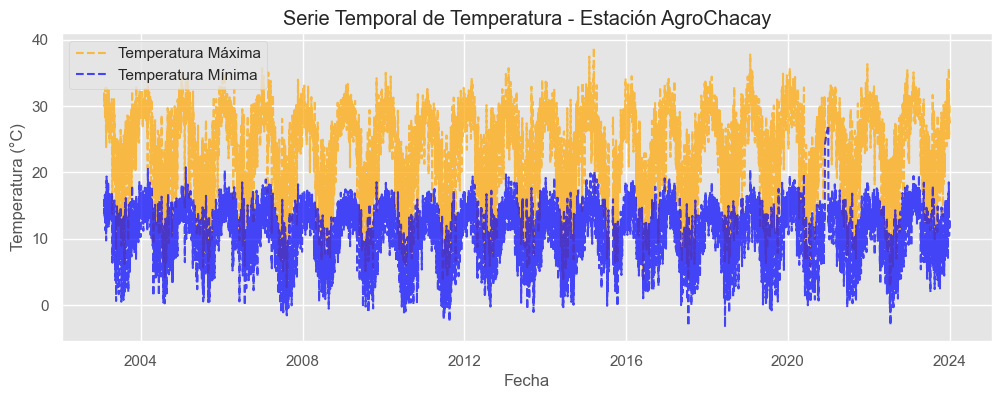

In [428]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# Filtrar por la estación 'AgroChacay'
df_agrochacay = df_imputado[df_imputado['Estacion'] == 'AgroChacay']

# Agrupar los datos por fecha y calcular la temperatura máxima y mínima
df_agrupado = df_agrochacay.groupby('Fecha').agg({'Valor_T_max': 'max', 'Valor_T_min': 'min'})

# Grafica la temperatura máxima y mínima, excluyendo los ceros
plt.figure(figsize=(12, 4))  # Ajustar el tamaño de la figura
plt.plot(df_agrupado.index, np.where(df_agrupado['Valor_T_max'] != 0, df_agrupado['Valor_T_max'], np.nan), label='Temperatura Máxima', color='orange', linestyle='--', alpha=0.7)
plt.plot(df_agrupado.index, np.where(df_agrupado['Valor_T_min'] != 0, df_agrupado['Valor_T_min'], np.nan), label='Temperatura Mínima', color='blue', linestyle='--', alpha=0.7)    

# Agregar título y etiquetas a los ejes
plt.title('Serie Temporal de Temperatura - Estación AgroChacay')
plt.xlabel('Fecha')
plt.ylabel('Temperatura (°C)')

# Mostrar leyenda
plt.legend()

# Mostrar la gráfica
plt.show()

C:\Users\cgodo\AppData\Local\Temp\ipykernel_31528\4125190266.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_agrochacay['Fecha'] = pd.to_datetime(df_agrochacay['Fecha'])


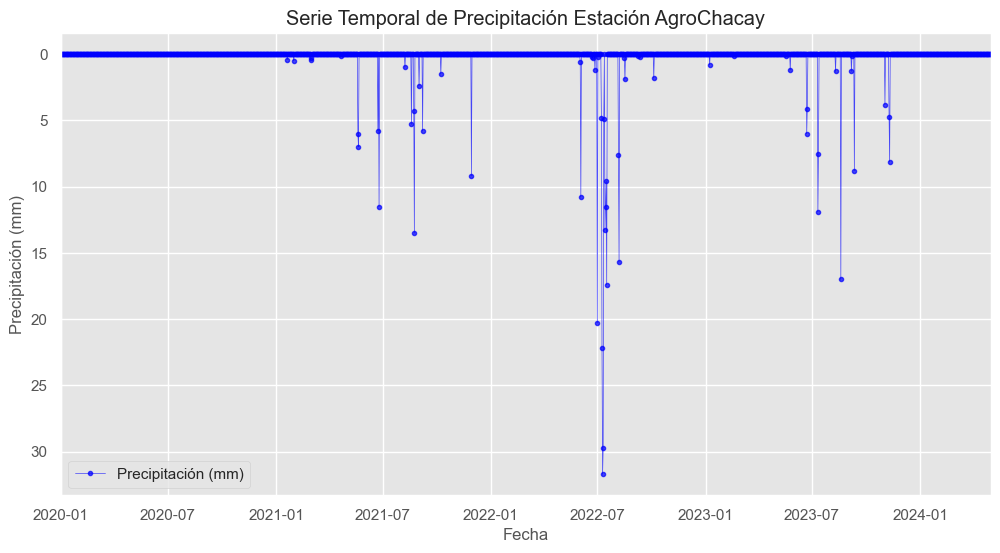

In [422]:
import pandas as pd
import matplotlib.pyplot as plt

# Filtrar por la estación 'AgroChacay'
df_agrochacay = df_imputado[df_imputado['Estacion'] == 'AgroChacay']

# Convertir la columna 'Fecha' a datetime
df_agrochacay['Fecha'] = pd.to_datetime(df_agrochacay['Fecha'])

# Ordenar por Fecha
df_agrochacay = df_agrochacay.sort_values(by='Fecha')

# Graficar la precipitación
plt.figure(figsize=(12, 6))  # Ajustar el tamaño de la figura
plt.plot(df_agrochacay['Fecha'], df_agrochacay['Valor_Pp_mm'], label='Precipitación (mm)', color='blue', marker='o', markersize=3, linestyle='-', linewidth=0.5, alpha=0.7)            

# Invertir el eje y
plt.gca().invert_yaxis()

# Establecer el límite inferior del eje x a 2020-01-01
plt.xlim(pd.Timestamp('2020-01-01'), df_agrochacay['Fecha'].max())

# Agregar título y etiquetas a los ejes
plt.title('Serie Temporal de Precipitación Estación AgroChacay')
plt.xlabel('Fecha')
plt.ylabel('Precipitación (mm)')

# Mostrar leyenda
plt.legend()

# Mostrar la gráfica
plt.show()

In [399]:
# Agrupar por 'Estacion' y calcular la media de 'lat' y 'long'
df_estaciones_agrupadas = df_importa_data.groupby('Estacion').agg({
    'lat': 'mean',
    'long': 'mean',
    'Coordenadas': 'first'  # Mantener la primera coordenada
}).reset_index()

df_estaciones_agrupadas.head()

,Estacion,lat,long,Coordenadas
0,AgroChacay,-31.863935,-70.616477,POINT (-70.61647709322419 -31.86393477004859)
1,AgroChungo,-31.888780,-71.493496,POINT (-71.49349570364026 -31.888780172246804)
2,Booster,-31.732623,-71.198516,POINT (-71.1985164878501 -31.732623010163)
3,Caimanes,-31.930710,-71.138814,POINT (-71.13881357717793 -31.93070977405118)
4,Camisas,-31.883650,-70.957379,POINT (-70.95737858778807 -31.883649750568733)


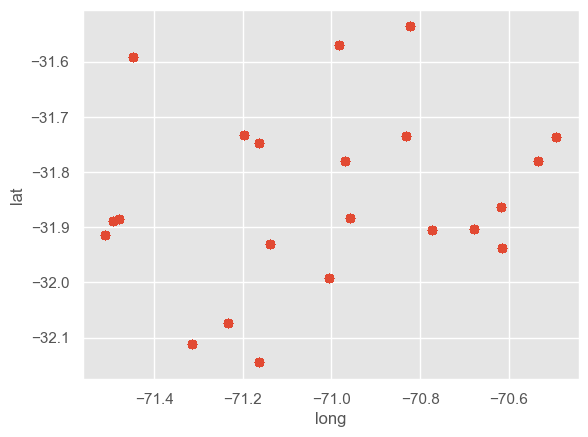

In [400]:
# Graficar estaciones como puntos
plt.scatter(df_importa_data["long"], df_importa_data["lat"])
plt.xlabel("long")
plt.ylabel("lat")
plt.show()

In [401]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# --- Cargar el shapefile de las regiones ---
shapefile_path = r'C:\Entorno_Desarrollo_UDD\Visualizacion_de_la_Informacion\data\Comunas\comunas.shp'  # ruta shapefile

# Leer el shapefile con GeoPandas
shape_comunas_gdf = gpd.read_file(shapefile_path)

# Ver las primeras filas del shapefile
print("Shapefile cargado:")
print(shape_comunas_gdf.head())

Shapefile cargado:
   objectid     shape_leng  dis_elec  cir_sena  cod_comuna  codregion  \
0        48  170038.624165        16         8        6204          6   
1        29  125730.104795        15         8        6102          6   
2        30   63026.084422        15         8        6103          6   
3        31   89840.903562        15         8        6104          6   
4        78  122626.493264        23        11        9121          9   

     st_area_sh     st_length_                                    Region  \
0  9.685774e+08  206184.271675  Región del Libertador Bernardo O'Higgins   
1  4.157446e+08  151911.576827  Región del Libertador Bernardo O'Higgins   
2  1.448565e+08   76355.326122  Región del Libertador Bernardo O'Higgins   
3  3.256572e+08  108874.623150  Región del Libertador Bernardo O'Higgins   
4  6.990727e+08  156680.410681                    Región de La Araucanía   

      Comuna      Provincia                                           geometry  
0  M

In [402]:
# Filtrar el GeoDataFrame para la Región de Coquimbo y la Provincia de Choapa
gdf_coquimbo_choapa = shape_comunas_gdf[(shape_comunas_gdf['codregion'] == 4) & (shape_comunas_gdf['Provincia'] == 'Choapa')]

# Mostrar las primeras filas del GeoDataFrame filtrado
gdf_coquimbo_choapa.head()

,objectid,shape_leng,dis_elec,cir_sena,cod_comuna,codregion,st_area_sh,st_length_,Region,Comuna,Provincia,geometry
211,64,281879.768370,5,5,4203,4,2.586951e+09,372268.897625,Región de Coquimbo,Los Vilos,Choapa,"MULTIPOLYGON (((-7964264.651 -3727784.991, -79..."
212,62,314433.003983,5,5,4202,4,3.023257e+09,414867.293177,Región de Coquimbo,Canela,Choapa,"POLYGON ((-7975718.051 -3661191.176, -7975718...."
245,63,360387.693145,5,5,4201,4,3.629837e+09,423986.085282,Región de Coquimbo,Illapel,Choapa,"POLYGON ((-7857583.146 -3669235.934, -7857509...."
301,65,372597.428712,5,5,4204,4,4.795458e+09,440576.778684,Región de Coquimbo,Salamanca,Choapa,"POLYGON ((-7826929.647 -3794667.682, -7826929...."


<Axes: >

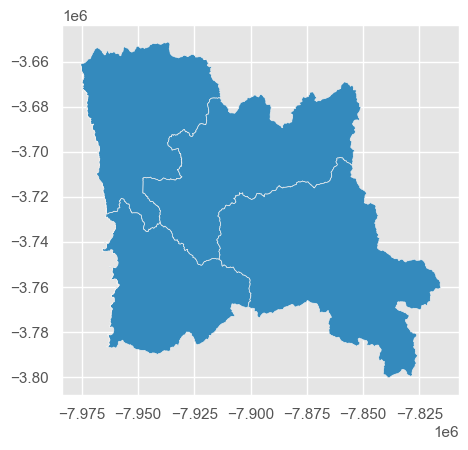

In [403]:
gdf_coquimbo_choapa.plot()

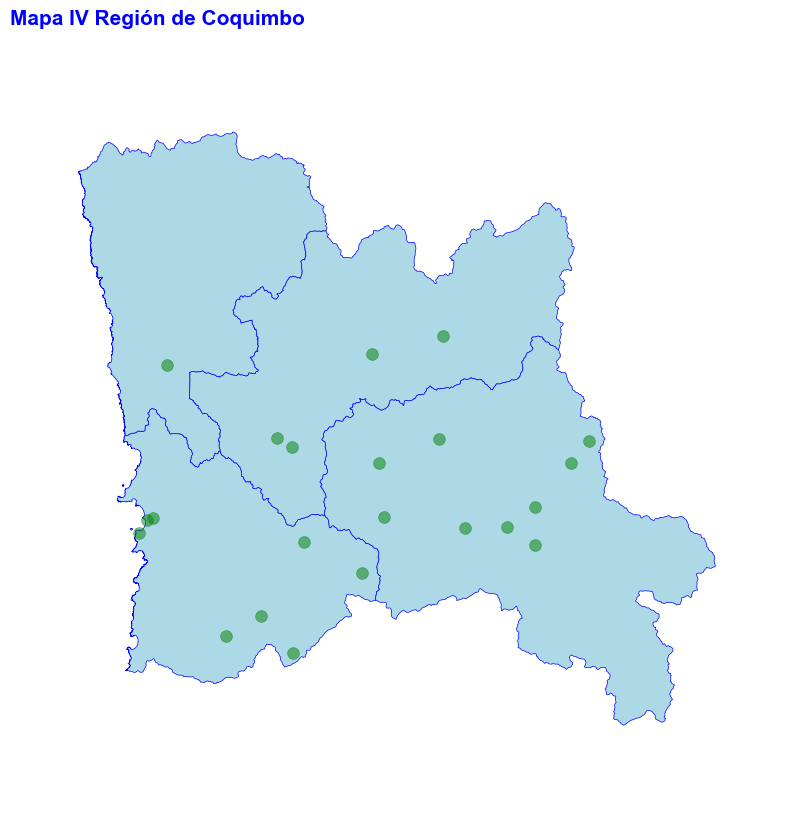

In [415]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Point

plt.style.use('ggplot')

# Convertir df_estaciones_agrupadas a un GeoDataFrame
df_estaciones_agrupadas['Coordenadas'] = df_estaciones_agrupadas.apply(lambda row: Point(row['long'], row['lat']), axis=1)
gdf_estaciones = gpd.GeoDataFrame(df_estaciones_agrupadas, geometry='Coordenadas')

# Asegurar que el CRS coincida
gdf_estaciones.set_crs(epsg=4326, inplace=True)  # Asignar CRS si no está asignado
gdf_estaciones = gdf_estaciones.to_crs(gdf_coquimbo_choapa.crs)  # Convertir CRS

# Filtrar el GeoDataFrame para la Región de Coquimbo y la Provincia de Choapa
gdf_coquimbo_choapa = shape_comunas_gdf[(shape_comunas_gdf['codregion'] == 4) & (shape_comunas_gdf['Provincia'] == 'Choapa')]

# Definir los límites del zoom
xmin = -7.993e6
xmax = -7.798e6
ymin = -3.82e6
ymax = -3.63e6

# Graficar el shapefile de la región de Coquimbo
fig, ax = plt.subplots(figsize=(10, 10))
gdf_coquimbo_choapa.plot(ax=ax, color='lightblue', edgecolor='blue')

# Graficar las estaciones en el mismo mapa
gdf_estaciones.plot(ax=ax, marker='o', color='green', markersize=72, alpha=0.5)

# Agregar título al gráfico
ax.set_title('Mapa IV Región de Coquimbo', fontsize=15, fontweight='bold', color='blue', fontname='Arial', loc='left')

# Apagar los ejes del mapa
ax.axis('off')

# Ajustar los límites del mapa para el zoom
ax.set_xlim(xmin, xmax) 
ax.set_ylim(ymin, ymax) 

plt.show()